In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import proplot as pplot
import matplotlib.pyplot as plt
from scipy.stats import linregress
import cmaps
import cnmaps

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import transform
from cnmaps import get_map, draw_map, clip_contours_by_map
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

import rioxarray
import geopandas
import pyhomogeneity as hg
from shapely.geometry import mapping

import os
os.chdir('/Users/zeqinhuang/Documents/paper/HW_track')

import warnings
warnings.filterwarnings('ignore')

# calculate anomalies for precipitation

In [2]:
reanalyses_dir = {
    'era5':'/Volumes/Seagate_HZQ/reanalyses/era5/',
    'jra55':'/Volumes/Seagate_HZQ/reanalyses/jra55/'
}

In [3]:
ds = 'era5'
for i in range(1979,2023):
    prec_i = xr.open_dataarray(reanalyses_dir[ds] + 'total_precipitation_daily_' + ds + '_' + str(i) + '.nc')
    prec_i = prec_i.sel(latitude = slice(54,17),longitude = slice(72,136))
    JJA = prec_i.time.dt.month.isin(range(6,9))
    prec_i = prec_i.sel(time=JJA)
    if i == 1979:
        prec_all = prec_i
    else:
        prec_all = xr.concat([prec_all,prec_i],dim='time')
prec_all.to_netcdf('data/prec_' + ds + '_' + '1979_2022_JJA.nc')
lon = prec_all.longitude
lat = prec_all.latitude
time = prec_all.time
nlon = len(lon)
nlat = len(lat)
prec_all_1979_2010_clim = prec_all.sel(time = prec_all.time.dt.year.isin(range(1979,2011))).values.reshape((32,92,nlat,nlon)).mean(axis=0)

prec_ano = np.empty((44*92,nlat,nlon))
for i in range(1979,2023):
    prec_ano[(i-1979)*92:(i-1979+1)*92,:,:] = prec_all.values[(i-1979)*92:(i-1979+1)*92,:,:] - prec_all_1979_2010_clim

prec_ano_da = xr.DataArray(data=prec_ano,coords=[time, lat, lon], dims = ['time','lat','lon'])
prec_ano_da_JJA = prec_ano_da.groupby('time.year').mean() 

The climatological mean of summer precipitation in YRB (1979-2010) is: 0.2139 (m)
The precipitation in YRB in 2022 is: 0.1569 (m)
The precipitation in YRB in 2022 is 26.62% lesser than climatological mean


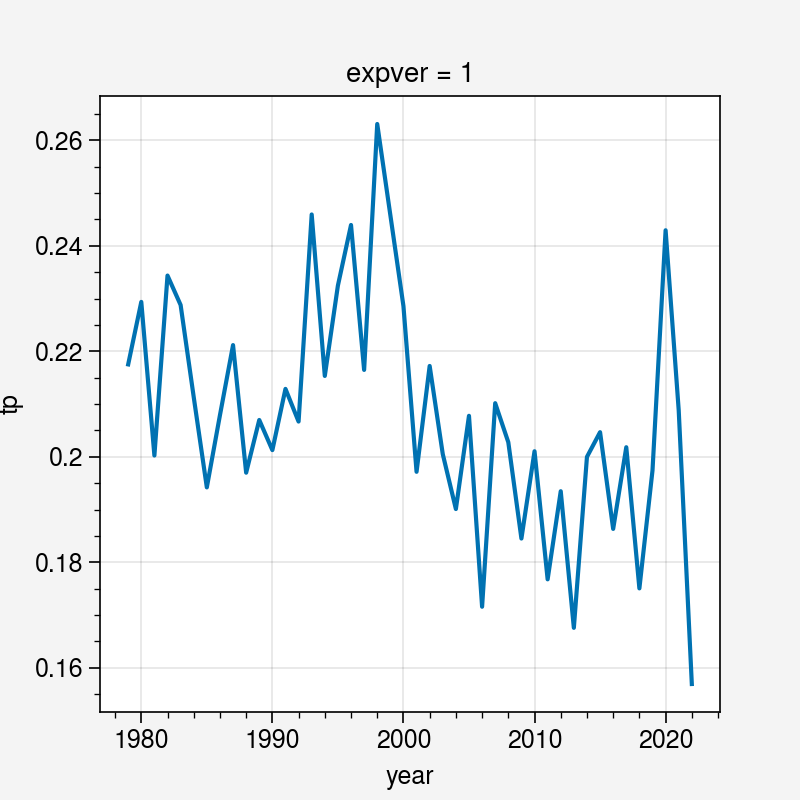

In [4]:
lon = prec_all.longitude
lat = prec_all.latitude
time = prec_all.time
nlon = len(lon)
nlat = len(lat)
prec_all_1979_2022 = prec_all.sel(time = prec_all.time.dt.year.isin(range(1979,2023))).groupby('time.year').sum(dim='time')
prec_all_1979_2022_YRB = prec_all_1979_2022.sel(latitude = slice(35,25),longitude = slice(100,122.5))
weights = np.cos(np.deg2rad(prec_all_1979_2022_YRB.latitude))
weights.name = 'weights'
prec_all_1979_2022_YRB_weighted = prec_all_1979_2022_YRB.weighted(weights)
prec_all_1979_2022_YRB_weighted_ts = prec_all_1979_2022_YRB_weighted.mean(('longitude','latitude'))
prec_all_1979_2022_YRB_weighted_ts.plot()

prec_2022 = prec_all_1979_2022_YRB_weighted_ts[-1].values.mean()
prec_clim = prec_all_1979_2022_YRB_weighted_ts[:32].values.mean()
print('The climatological mean of summer precipitation in YRB (1979-2010) is: ' + str(round(prec_clim,4)) + ' (m)')
print('The precipitation in YRB in 2022 is: ' + str(round(prec_2022,4)) + ' (m)')
print('The precipitation in YRB in 2022 is ' + str(round((prec_clim - prec_2022) / prec_clim * 100,2)) + '% lesser than climatological mean')

# calculate anomalies for total cloud cover

In [5]:
ds = 'era5'
for i in range(1979,2023):
    tcc_i = xr.open_dataarray(reanalyses_dir[ds] + 'total_cloud_cover_daily_' + ds + '_' + str(i) + '.nc')
    tcc_i = tcc_i.sel(latitude = slice(54,17),longitude = slice(72,136))
    JJA = tcc_i.time.dt.month.isin(range(6,9))
    tcc_i = tcc_i.sel(time=JJA)
    if i == 1979:
        tcc_all = tcc_i
    else:
        tcc_all = xr.concat([tcc_all,tcc_i],dim='time')
tcc_all.to_netcdf('data/tcc_' + ds + '_' + '1979_2022_JJA.nc')
lon = tcc_all.longitude
lat = tcc_all.latitude
time = tcc_all.time
nlon = len(lon)
nlat = len(lat)
tcc_all_1979_2010_clim = tcc_all.sel(time = tcc_all.time.dt.year.isin(range(1979,2011))).values.reshape((32,92,nlat,nlon)).mean(axis=0)

tcc_ano = np.empty((44*92,nlat,nlon))
for i in range(1979,2023):
    tcc_ano[(i-1979)*92:(i-1979+1)*92,:,:] = tcc_all.values[(i-1979)*92:(i-1979+1)*92,:,:] - tcc_all_1979_2010_clim

tcc_ano_da = xr.DataArray(data=tcc_ano,coords=[time, lat, lon], dims = ['time','lat','lon'])
tcc_ano_da_JJA = tcc_ano_da.groupby('time.year').mean() 

The climatological mean of summer tccipitation in YRB (1979-2010) is: 74.1326 (%)
The tccipitation in YRB in 2022 is: 70.5453 (%)
The tccipitation in YRB in 2022 is 4.84% lesser than climatological mean


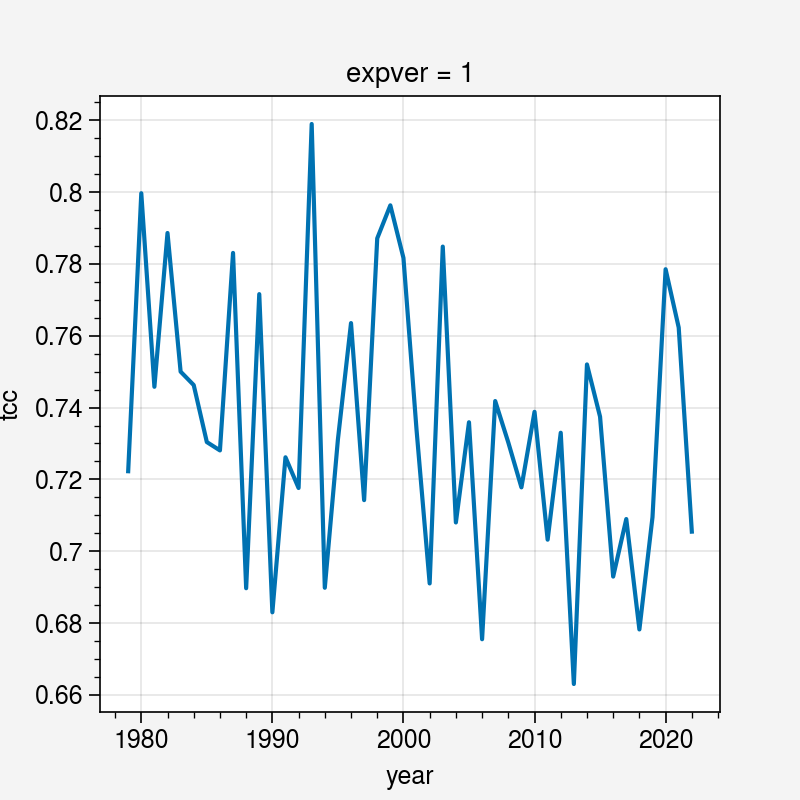

In [6]:
lon = tcc_all.longitude
lat = tcc_all.latitude
time = tcc_all.time
nlon = len(lon)
nlat = len(lat)
tcc_all_1979_2022 = tcc_all.sel(time = tcc_all.time.dt.year.isin(range(1979,2023))).groupby('time.year').mean(dim='time')
tcc_all_1979_2022_YRB = tcc_all_1979_2022.sel(latitude = slice(35,25),longitude = slice(100,122.5))
weights = np.cos(np.deg2rad(tcc_all_1979_2022_YRB.latitude))
weights.name = 'weights'
tcc_all_1979_2022_YRB_weighted = tcc_all_1979_2022_YRB.weighted(weights)
tcc_all_1979_2022_YRB_weighted_ts = tcc_all_1979_2022_YRB_weighted.mean(('longitude','latitude'))
tcc_all_1979_2022_YRB_weighted_ts.plot()

tcc_2022 = tcc_all_1979_2022_YRB_weighted_ts[-1].values.mean()
tcc_clim = tcc_all_1979_2022_YRB_weighted_ts[:32].values.mean()
print('The climatological mean of summer tccipitation in YRB (1979-2010) is: ' + str(round(tcc_clim*100,4)) + ' (%)')
print('The tccipitation in YRB in 2022 is: ' + str(round(tcc_2022*100,4)) + ' (%)')
print('The tccipitation in YRB in 2022 is ' + str(round((tcc_clim - tcc_2022) / tcc_clim * 100,2)) + '% lesser than climatological mean')

# calculate anomalies for maximum surface temperature

In [7]:
ds = 'era5'
for i in range(1979,2023):
    tmax_i = xr.open_dataarray(reanalyses_dir[ds] + 'maximum_2m_temperature_since_previous_post_processing_daily_' + ds + '_' + str(i) + '.nc')
    tmax_i = tmax_i.sel(latitude = slice(54,17),longitude = slice(72,136))
    JJA = tmax_i.time.dt.month.isin(range(6,9))
    tmax_i = tmax_i.sel(time=JJA)
    if i == 1979:
        tmax_all = tmax_i
    else:
        tmax_all = xr.concat([tmax_all,tmax_i],dim='time')
tmax_all.to_netcdf('data/tmax_' + ds + '_' + '1979_2022_JJA.nc')
lon = tmax_all.longitude
lat = tmax_all.latitude
time = tmax_all.time
nlon = len(lon)
nlat = len(lat)
tmax_all_1979_2010_clim = tmax_all.sel(time = tmax_all.time.dt.year.isin(range(1979,2011))).values.reshape((32,92,nlat,nlon)).mean(axis=0)

tmax_ano = np.empty((44*92,nlat,nlon))
for i in range(1979,2023):
    tmax_ano[(i-1979)*92:(i-1979+1)*92,:,:] = tmax_all.values[(i-1979)*92:(i-1979+1)*92,:,:] - tmax_all_1979_2010_clim

tmax_ano_da = xr.DataArray(data=tmax_ano,coords=[time, lat, lon], dims = ['time','lat','lon'])
tmax_ano_da_JJA = tmax_ano_da.groupby('time.year').mean() 

In [8]:
lon = tmax_all.longitude
lat = tmax_all.latitude
time = tmax_all.time
nlon = len(lon)
nlat = len(lat)
tmax_all_1979_2022 = tmax_all.sel(time = tmax_all.time.dt.year.isin(range(1979,2023))).groupby('time.year').mean(dim='time')
tmax_all_1979_2022_YRB = tmax_all_1979_2022.sel(latitude = slice(35,25),longitude = slice(100,122.5))
weights = np.cos(np.deg2rad(tmax_all_1979_2022_YRB.latitude))
weights.name = 'weights'
tmax_all_1979_2022_YRB_weighted = tmax_all_1979_2022_YRB.weighted(weights)
tmax_all_1979_2022_YRB_weighted_ts = tmax_all_1979_2022_YRB_weighted.mean(('longitude','latitude'))
# tmax_all_1979_2022_YRB_weighted_ts.plot()

tmax_2022 = tmax_all_1979_2022_YRB_weighted_ts[-1].values.mean()
tmax_clim = tmax_all_1979_2022_YRB_weighted_ts.sel(year=tmax_all_1979_2022_YRB_weighted_ts.year.isin(list(range(1979,1992))+list(range(1993,2011)))).values.mean()
print('The climatological mean of summer tmaxipitation in YRB (1979-2010) is: ' + str(round(tmax_clim-273,4)) + ' (°C)')
print('The tmaxipitation in YRB in 2022 is: ' + str(round(tmax_2022-273,4)) + ' (°C)')
print('The tmaxipitation in YRB in 2022 is ' + str(round((tmax_2022 - tmax_clim),2)) + '°C higher than climatological mean')

The climatological mean of summer tmaxipitation in YRB (1979-2010) is: 23.0868 (°C)
The tmaxipitation in YRB in 2022 is: 24.9781 (°C)
The tmaxipitation in YRB in 2022 is 1.89°C higher than climatological mean


In [9]:
print('The climatological mean of summer tmaxipitation in YRB (1979-2010) is: ' + str(round(tmax_clim-273,4)) + ' (°C)')
print('The tmaxipitation in YRB in 2022 is: ' + str(round(tmax_2022-273,4)) + ' (°C)')
print('The tmaxipitation in YRB in 2022 is ' + str(round((tmax_2022 - tmax_clim),2)) + '°C higher than climatological mean')

The climatological mean of summer tmaxipitation in YRB (1979-2010) is: 23.0868 (°C)
The tmaxipitation in YRB in 2022 is: 24.9781 (°C)
The tmaxipitation in YRB in 2022 is 1.89°C higher than climatological mean


# calculate anomalies for 500hpa geopotential height

In [10]:
ds = 'era5'
for i in range(1979,2023):
    z500_i = xr.open_dataarray(reanalyses_dir[ds] + 'GPH500_daily_' + ds + '_' + str(i) + '.nc')
    z500_i = z500_i.sel(latitude = slice(60,0),longitude = slice(70,170))
    JJA = z500_i.time.dt.month.isin(range(6,9))
    z500_i = z500_i.sel(time=JJA)
    if i == 1979:
        z500_all = z500_i
    else:
        z500_all = xr.concat([z500_all,z500_i],dim='time')
z500_all.to_netcdf('data/z500_' + ds + '_' + '1979_2022_JJA.nc')
lon = z500_all.longitude
lat = z500_all.latitude
time = z500_all.time
nlon = len(lon)
nlat = len(lat)
z500_all_1979_2010_clim = z500_all.sel(time = z500_all.time.dt.year.isin(range(1979,2011))).values.reshape((32,92,nlat,nlon)).mean(axis=0)

z500_ano = np.empty((44*92,nlat,nlon))
for i in range(1979,2023):
    z500_ano[(i-1979)*92:(i-1979+1)*92,:,:] = z500_all.values[(i-1979)*92:(i-1979+1)*92,:,:] - z500_all_1979_2010_clim

z500_ano_da = xr.DataArray(data=z500_ano,coords=[time, lat, lon], dims = ['time','lat','lon'])
z500_ano_da_JJA = z500_ano_da.groupby('time.year').mean() 

In [11]:
z500_all_2022_JJA_mean = z500_all.sel(time = z500_all.time.dt.year==2022).mean(axis=0)
z500_all_JJA_clim_mean = z500_all.sel(time = z500_all.time.dt.year.isin(range(1979,2011))).mean(axis=0)

# calculate anomalies for 850hpa vwind

In [13]:
ds = 'era5'
for i in range(1979,2023):
    v_i = xr.open_dataarray(reanalyses_dir[ds] + 'v_component_of_wind_daily_' + ds + '_' + str(i) + '.nc')
    v850_i = v_i.sel(level=850)
    v850_i = v850_i.sel(latitude = slice(60,0),longitude = slice(70,170))
    JJA = v850_i.time.dt.month.isin(range(6,9))
    v850_i = v850_i.sel(time=JJA)
    if i == 1979:
        v850_all = v850_i
    else:
        v850_all = xr.concat([v850_all,v850_i],dim='time')
v850_all.to_netcdf('data/v850_' + ds + '_' + '1979_2022_JJA.nc')
lon = v850_all.longitude
lat = v850_all.latitude
time = v850_all.time
nlon = len(lon)
nlat = len(lat)
v850_all_1979_2010_clim = v850_all.sel(time = v850_all.time.dt.year.isin(range(1979,2011))).values.reshape((32,92,nlat,nlon)).mean(axis=0)

v850_ano = np.empty((44*92,nlat,nlon))
for i in range(1979,2023):
    v850_ano[(i-1979)*92:(i-1979+1)*92,:,:] = v850_all.values[(i-1979)*92:(i-1979+1)*92,:,:] - v850_all_1979_2010_clim

v850_ano_da = xr.DataArray(data=v850_ano,coords=[time, lat, lon], dims = ['time','lat','lon'])
v850_ano_da_JJA = v850_ano_da.groupby('time.year').mean() 

# calculate anomalies for 850hpa uwind

In [14]:
ds = 'era5'
for i in range(1979,2023):
    u_i = xr.open_dataarray(reanalyses_dir[ds] + 'u_component_of_wind_daily_' + ds + '_' + str(i) + '.nc')
    u850_i = u_i.sel(level=850)
    u850_i = u850_i.sel(latitude = slice(60,0),longitude = slice(70,170))
    JJA = u850_i.time.dt.month.isin(range(6,9))
    u850_i = u850_i.sel(time=JJA)
    if i == 1979:
        u850_all = u850_i
    else:
        u850_all = xr.concat([u850_all,u850_i],dim='time')
u850_all.to_netcdf('data/u850_' + ds + '_' + '1979_2022_JJA.nc')
lon = u850_all.longitude
lat = u850_all.latitude
time = u850_all.time
nlon = len(lon)
nlat = len(lat)
u850_all_1979_2010_clim = u850_all.sel(time = u850_all.time.dt.year.isin(range(1979,2011))).values.reshape((32,92,nlat,nlon)).mean(axis=0)

u850_ano = np.empty((44*92,nlat,nlon))
for i in range(1979,2023):
    u850_ano[(i-1979)*92:(i-1979+1)*92,:,:] = u850_all.values[(i-1979)*92:(i-1979+1)*92,:,:] - u850_all_1979_2010_clim

u850_ano_da = xr.DataArray(data=u850_ano,coords=[time, lat, lon], dims = ['time','lat','lon'])
u850_ano_da_JJA = u850_ano_da.groupby('time.year').mean() 

# calculate anomalies for 250hpa vwind

In [15]:
ds = 'era5'
for i in range(1979,2023):
    v_i = xr.open_dataarray(reanalyses_dir[ds] + 'v_component_of_wind_daily_' + ds + '_' + str(i) + '.nc')
    v250_i = v_i.sel(level=250)
    v250_i = v250_i.sel(latitude = slice(60,0),longitude = slice(70,170))
    JJA = v250_i.time.dt.month.isin(range(6,9))
    v250_i = v250_i.sel(time=JJA)
    if i == 1979:
        v250_all = v250_i
    else:
        v250_all = xr.concat([v250_all,v250_i],dim='time')
v250_all.to_netcdf('data/v250_' + ds + '_' + '1979_2022_JJA.nc')
lon = v250_all.longitude
lat = v250_all.latitude
time = v250_all.time
nlon = len(lon)
nlat = len(lat)
v250_all_1979_2010_clim = v250_all.sel(time = v250_all.time.dt.year.isin(range(1979,2011))).values.reshape((32,92,nlat,nlon)).mean(axis=0)

v250_ano = np.empty((44*92,nlat,nlon))
for i in range(1979,2023):
    v250_ano[(i-1979)*92:(i-1979+1)*92,:,:] = v250_all.values[(i-1979)*92:(i-1979+1)*92,:,:] - v250_all_1979_2010_clim

v250_ano_da = xr.DataArray(data=v250_ano,coords=[time, lat, lon], dims = ['time','lat','lon'])
v250_ano_da_JJA = v250_ano_da.groupby('time.year').mean() 

# calculate anomalies for 250hpa uwind

In [16]:
ds = 'era5'
for i in range(1979,2023):
    u_i = xr.open_dataarray(reanalyses_dir[ds] + 'u_component_of_wind_daily_' + ds + '_' + str(i) + '.nc')
    u250_i = u_i.sel(level=250)
    u250_i = u250_i.sel(latitude = slice(60,0),longitude = slice(70,170))
    JJA = u250_i.time.dt.month.isin(range(6,9))
    u250_i = u250_i.sel(time=JJA)
    if i == 1979:
        u250_all = u250_i
    else:
        u250_all = xr.concat([u250_all,u250_i],dim='time')
u250_all.to_netcdf('data/u250_' + ds + '_' + '1979_2022_JJA.nc')
lon = u250_all.longitude
lat = u250_all.latitude
time = u250_all.time
nlon = len(lon)
nlat = len(lat)
u250_all_1979_2010_clim = u250_all.sel(time = u250_all.time.dt.year.isin(range(1979,2011))).values.reshape((32,92,nlat,nlon)).mean(axis=0)

u250_ano = np.empty((44*92,nlat,nlon))
for i in range(1979,2023):
    u250_ano[(i-1979)*92:(i-1979+1)*92,:,:] = u250_all.values[(i-1979)*92:(i-1979+1)*92,:,:] - u250_all_1979_2010_clim

u250_ano_da = xr.DataArray(data=u250_ano,coords=[time, lat, lon], dims = ['time','lat','lon'])
u250_ano_da_JJA = u250_ano_da.groupby('time.year').mean() 

# plot the composites for horizontal patterns

In [17]:
from descartes import PolygonPatch
import shapefile
import matplotlib.path as mpath
import matplotlib.patches as mpatches
source_path = 'shapefiles/country.shp'

Path = mpath.Path
sfile = shapefile.Reader(source_path)
for shape_rec in sfile.shapeRecords():
    vertices = []
    codes = []
    pts = shape_rec.shape.points
    prt = list(shape_rec.shape.parts) + [len(pts)]
    for i in range(len(prt) - 1):
        for j in range(prt[i], prt[i+1]):
            vertices.append((pts[j][0], pts[j][1]))
        codes += [Path.MOVETO]
        codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
        codes += [Path.CLOSEPOLY]
    clip = mpath.Path(vertices, codes)
    clip = mpatches.PathPatch(clip,visible=False,transform=ccrs.PlateCarree())

## calculate anomalies for geopotential height across pressure levels

In [18]:
ds = 'era5'
for i in range(1979,2023):
    z_i = xr.open_dataarray(reanalyses_dir[ds] + 'geopotential_daily_' + ds + '_' + str(i) + '.nc')
    z_i = z_i.sel(latitude = slice(60,0),longitude = slice(70,170))
    JJA = z_i.time.dt.month.isin(range(6,9))
    z_i = z_i.sel(time=JJA)
    if i == 1979:
        z_all = z_i
    else:
        z_all = xr.concat([z_all,z_i],dim='time')
z_all.to_netcdf('data/z_' + ds + '_' + '1979_2022_JJA.nc')
ds = 'era5'
z_all = xr.open_dataarray('data/z_' + ds + '_' + '1979_2022_JJA.nc')
lon = z_all.longitude
lat = z_all.latitude
time = z_all.time
level = z_all.level
nlon = len(lon)
nlat = len(lat)
z_all_1979_2010_clim = z_all.sel(time = z_all.time.dt.year.isin(range(1979,2023))).values.reshape((44,92,8,nlat,nlon)).mean(axis=0)

z_ano = np.empty((44*92,8,nlat,nlon))
for i in range(1979,2023):
    z_ano[(i-1979)*92:(i-1979+1)*92,:,:,:] = z_all.values[(i-1979)*92:(i-1979+1)*92,:,:,:] - z_all_1979_2010_clim

z_ano_da = xr.DataArray(data=z_ano,coords=[time, level, lat, lon], dims = ['time','level','lat','lon'])
z_ano_da_JJA = z_ano_da.groupby('time.year').mean() / 9.80664

In [19]:
z_ano_da_JJA_2022 = z_ano_da_JJA.sel(year=2022)
z_ano_da_JJA_2022 = z_ano_da_JJA_2022.sel(lat=slice(35,25)).mean(axis=1)  # cross section along 25-35N

## calculate anomalies for air temperature across pressure levels

In [20]:
ds = 'era5'
for i in range(1979,2023):
    temp_i = xr.open_dataarray(reanalyses_dir[ds] + 'temperature_daily_' + ds + '_' + str(i) + '.nc')
    temp_i = temp_i.sel(latitude = slice(60,0),longitude = slice(70,170))
    JJA = temp_i.time.dt.month.isin(range(6,9))
    temp_i = temp_i.sel(time=JJA)
    if i == 1979:
        temp_all = temp_i
    else:
        temp_all = xr.concat([temp_all,temp_i],dim='time')
temp_all.to_netcdf('data/temp_' + ds + '_' + '1979_2022_JJA.nc')
lon = temp_all.longitude
lat = temp_all.latitude
time = temp_all.time
level = temp_all.level
nlon = len(lon)
nlat = len(lat)
temp_all_1979_2010_clim = temp_all.sel(time = temp_all.time.dt.year.isin(range(1979,2011))).values.reshape((32,92,8,nlat,nlon)).mean(axis=0)

temp_ano = np.empty((44*92,8,nlat,nlon))
for i in range(1979,2023):
    temp_ano[(i-1979)*92:(i-1979+1)*92,:,:,:] = temp_all.values[(i-1979)*92:(i-1979+1)*92,:,:,:] - temp_all_1979_2010_clim

temp_ano_da = xr.DataArray(data=temp_ano,coords=[time, level, lat, lon], dims = ['time','level','lat','lon'])
temp_ano_da_JJA = temp_ano_da.groupby('time.year').mean()

temp_ano_da_JJA_2022 = temp_ano_da_JJA.sel(year=2022).sel(lon=slice(100,122.5)).mean(axis=2)

## calculate anomalies for relative humidity across pressure levels

In [21]:
ds = 'era5'
for i in range(1979,2023):
    rh_i = xr.open_dataarray(reanalyses_dir[ds] + 'relative_humidity_daily_' + ds + '_' + str(i) + '.nc')
    rh_i = rh_i.sel(latitude = slice(60,0),longitude = slice(70,170))
    JJA = rh_i.time.dt.month.isin(range(6,9))
    rh_i = rh_i.sel(time=JJA)
    if i == 1979:
        rh_all = rh_i
    else:
        rh_all = xr.concat([rh_all,rh_i],dim='time')
rh_all.to_netcdf('data/rh_' + ds + '_' + '1979_2022_JJA.nc')
rh_all = xr.open_dataarray('data/rh_' + ds + '_' + '1979_2022_JJA.nc')
lon = rh_all.longitude
lat = rh_all.latitude
time = rh_all.time
level = rh_all.level
nlon = len(lon)
nlat = len(lat)
rh_all_1979_2010_clim = rh_all.sel(time = rh_all.time.dt.year.isin(range(1979,2011))).values.reshape((32,92,8,nlat,nlon)).mean(axis=0)

rh_ano = np.empty((44*92,8,nlat,nlon))
for i in range(1979,2023):
    rh_ano[(i-1979)*92:(i-1979+1)*92,:,:,:] = rh_all.values[(i-1979)*92:(i-1979+1)*92,:,:,:] - rh_all_1979_2010_clim

rh_ano_da = xr.DataArray(data=rh_ano,coords=[time, level, lat, lon], dims = ['time','level','lat','lon'])
rh_ano_da_JJA = rh_ano_da.groupby('time.year').mean()

rh_ano_da_JJA_2022 = rh_ano_da_JJA.sel(year=2022).sel(lon=slice(100,122.5)).mean(axis=2)

## plot

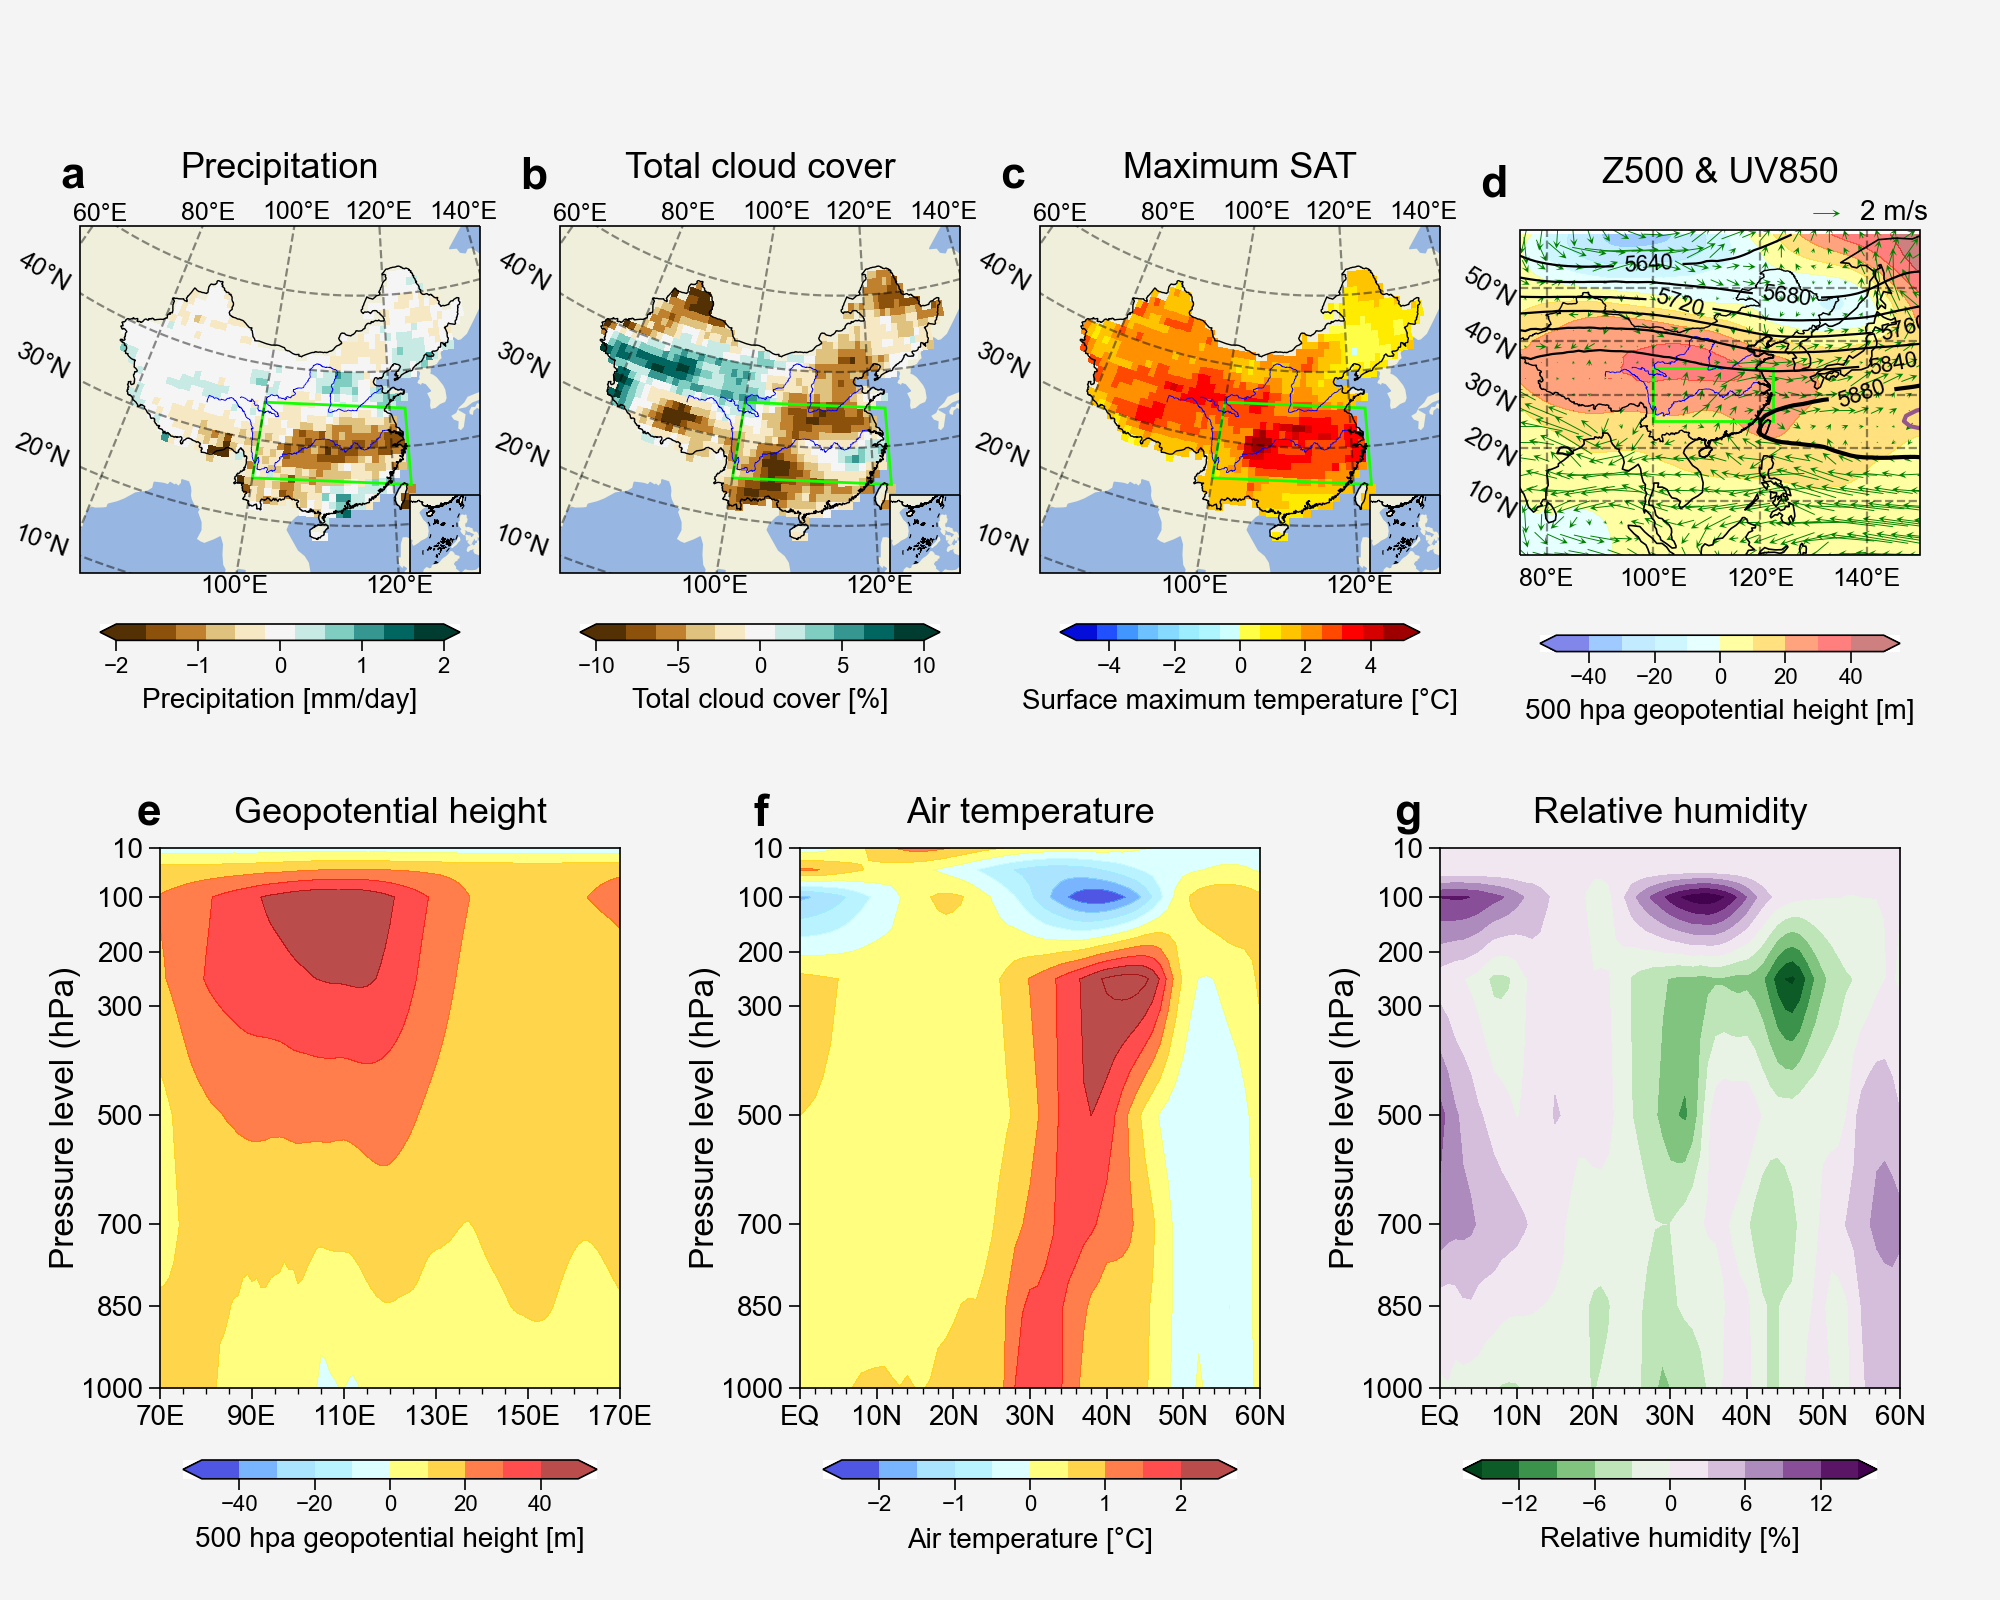

In [43]:
from matplotlib.patches import Rectangle
import matplotlib as mpl
from copy import copy
plt.rcParams["font.family"] = "Arial"

axes_locs = [
    [0.04,0.55,0.2,0.4],
    [0.28,0.55,0.2,0.4],
    [0.52,0.55,0.2,0.4],
    [0.76,0.54,0.2,0.42],
]

sub_axes_locs = [
    [0.245-0.04, 0.641, 0.035, 0.05],
    [0.445, 0.641, 0.035, 0.05],
    [0.735-0.05, 0.641, 0.035, 0.05]
]

# data for drawing South China sea
with open('shapefiles/CN-border-L1.dat') as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]


china = get_map('中国')
river = shpreader.Reader('shapefiles/yangtze_yellow_river.shp')
river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.3)

fig = plt.figure(figsize = (10,8))

# ax1 for precipitation
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=115)
ax1 = fig.add_axes(axes_locs[0], projection = mapcrs)
clip_copy = copy(clip)
ax1.add_patch(clip_copy)

ax1.add_feature(cfeature.LAND.with_scale('110m'))
ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
ax1.add_feature(river_feature)
ax1.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,transform=ccrs.PlateCarree()))
ax1.set_extent([80, 130, 13, 55])
ax1.set_title('Precipitation',fontdict={'fontsize':13,'fontweight': 'medium'},y=1.1)
draw_map(china,color='black',linewidth=0.5)

sub_ax = fig.add_axes(sub_axes_locs[0], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))
sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', color='black',transform=ccrs.Geodetic(),linewidth=0.4)
sub_ax.set_extent([105, 125, 0, 25])

prec_ano_da_JJA_2022 = prec_ano_da_JJA[-1]*1000
prec_ano_da_JJA_2022.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
prec_ano_da_JJA_2022.rio.write_grid_mapping(inplace=True)
prec_ano_da_JJA_2022.rio.write_crs("epsg:4326", inplace=True)
china_shp = geopandas.read_file('shapefiles/country.shp')
clipped = prec_ano_da_JJA_2022.rio.clip(china_shp.geometry.apply(mapping),drop=False)
p1 = ax1.pcolormesh(clipped.lon, clipped.lat, clipped, cmap=cmaps.CBR_drywet, vmin=-2, vmax=2, transform=ccrs.PlateCarree(),)

fig_cbar = fig.colorbar(p1, ax=ax1, location='bottom', shrink = 0.9, extend = 'both',pad=0.08)
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.set_label('Precipitation [mm/day]',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
gl1.right_labels = False

# ax2 for total cloud cover
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=115)
ax2 = fig.add_axes(axes_locs[1], projection = mapcrs)
clip_copy = copy(clip)
ax2.add_patch(clip_copy)

ax2.add_feature(cfeature.LAND.with_scale('110m'))
ax2.add_feature(cfeature.OCEAN.with_scale('110m'))
ax2.add_feature(river_feature)
ax2.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,transform=ccrs.PlateCarree()))
ax2.set_extent([80, 130, 13, 55])
ax2.set_title('Total cloud cover',fontdict={'fontsize':13,'fontweight': 'medium'},y=1.1)
draw_map(china,color='black',linewidth=0.5)

sub_ax = fig.add_axes(sub_axes_locs[1], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))
sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', color='black',transform=ccrs.Geodetic(),linewidth=0.4)
sub_ax.set_extent([105, 125, 0, 25])

tcc_ano_da_JJA_2022 = tcc_ano_da_JJA[-1] * 100
tcc_ano_da_JJA_2022.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
tcc_ano_da_JJA_2022.rio.write_grid_mapping(inplace=True)
tcc_ano_da_JJA_2022.rio.write_crs("epsg:4326", inplace=True)
clipped = tcc_ano_da_JJA_2022.rio.clip(china_shp.geometry.apply(mapping),drop=False)
p1 = ax2.pcolormesh(clipped.lon, clipped.lat, clipped, cmap=cmaps.CBR_drywet, vmin=-10, vmax=10, transform=ccrs.PlateCarree(),)

fig_cbar = fig.colorbar(p1, ax=ax2, location='bottom', shrink = 0.9, extend = 'both',pad=0.08)
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.set_label('Total cloud cover [%]',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
gl2.xlabel_style = {'rotation': 0, 'ha':'center'}
# gl2.left_labels = False
gl2.right_labels = False

# ax3 for surface maximum temperature
ax3 = fig.add_axes(axes_locs[2], projection = mapcrs)
clip_copy = copy(clip)
ax3.add_patch(clip_copy)

ax3.add_feature(cfeature.LAND.with_scale('110m'))
ax3.add_feature(cfeature.OCEAN.with_scale('110m'))
ax3.add_feature(river_feature)
ax3.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,transform=ccrs.PlateCarree()))
ax3.set_extent([80, 130, 13, 55])
ax3.set_title('Maximum SAT',fontdict={'fontsize':13,'fontweight': 'medium'},y=1.1)
draw_map(china,color='black',linewidth=0.5)

sub_ax = fig.add_axes(sub_axes_locs[2], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))
sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', color='black',transform=ccrs.Geodetic(),linewidth=0.4)
sub_ax.set_extent([105, 125, 0, 25])

tmax_ano_da_JJA_2022 = tmax_ano_da_JJA[-1]
tmax_ano_da_JJA_2022.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
tmax_ano_da_JJA_2022.rio.write_grid_mapping(inplace=True)
tmax_ano_da_JJA_2022.rio.write_crs("epsg:4326", inplace=True)
clipped = tmax_ano_da_JJA_2022.rio.clip(china_shp.geometry.apply(mapping),drop=False)
p1 = ax3.pcolormesh(clipped.lon, clipped.lat, clipped, cmap=cmaps.GMT_panoply, vmin=-5, vmax=5, transform=ccrs.PlateCarree(),)

fig_cbar = fig.colorbar(p1, ax=ax3, location='bottom', shrink = 0.9, extend = 'both',pad=0.08)
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.set_label('Surface maximum temperature [°C]',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
gl3.xlabel_style = {'rotation': 0, 'ha':'center'}
# gl3.left_labels = False
gl3.right_labels = False

# ax4 for GPH500
mapcrs = ccrs.PlateCarree()
ax4 = fig.add_axes(axes_locs[3], projection = mapcrs)
ax4.add_feature(cfeature.COASTLINE.with_scale('110m'))
ax4.add_feature(river_feature)
ax4.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,transform=ccrs.PlateCarree()))
ax4.set_extent([75, 150, 0, 55])
ax4.set_title('Z500 & UV850',fontdict={'fontsize':13,'fontweight': 'medium'},y=1.1)
draw_map(china,color='black',linewidth=0.5)

lon = z500_ano_da_JJA['lon']
lat = z500_ano_da_JJA['lat']
p1 = ax4.contourf(lon,lat,z500_ano_da_JJA[-1], cmap=cmaps.GMT_panoply, levels=[-50,-40,-30,-20,-10,0,10,20,30,40,50], transform=ccrs.PlateCarree(),extend = 'both',alpha=0.5)
p6 = ax4.contour(lon,lat,z500_all_2022_JJA_mean,levels=[5880],colors=('black',),linestyles=('-',),linewidths=(1.5,))
ax4.contour(lon,lat,z500_all_JJA_clim_mean,levels=[5880],colors=('purple',),linestyles=('-',),linewidths=(1.5,))
p3 = ax4.contour(lon,lat,z500_all_2022_JJA_mean,levels=[5640,5680,5720,5760,5800,5840],colors=('black',),linestyles=('-',),linewidths=(0.8,))
ax4.clabel(p6, inline=True, fontsize=8,)
ax4.clabel(p3, inline=True, fontsize=8,)

fig_cbar = fig.colorbar(p1, ax=ax4, location='bottom', shrink = 0.9, extend = 'both',pad=0.12)
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.set_label('500 hpa geopotential height [m]',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

p4 = ax4.quiver(
        lon[::3], lat[::3], u850_ano_da_JJA[-1][::3,::3], v850_ano_da_JJA[-1][::3,::3],color='green',linewidth=1.5,
        pivot='middle',alpha=1,headlength=8,headwidth = 8,minshaft=1, scale=30)
ax4.quiverkey(p4, 0.8, 1.05, 2, r'2 m/s', labelpos='E', fontproperties={'size':10},)

gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
gl4.xlabel_style = {'rotation': 0, 'ha':'center'}
gl4.right_labels = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
gl4.ylocator = mticker.FixedLocator([0,10,20,30,40,50])
gl4.xlocator = mticker.FixedLocator([80,100,120,140])
gl4.xformatter = LONGITUDE_FORMATTER
gl4.yformatter = LATITUDE_FORMATTER
gl4.xlabel_style = {'rotation': 0, 'ha':'center'}
gl4.ylabel_style = {'rotation': -30, 'ha':'center'}
gl4.right_labels = False
gl4.top_labels = False

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='left')

add_panel_label(ax1, 'a', x=-0.05, y = 1.2)
add_panel_label(ax2, 'b', x=-0.1, y = 1.2)
add_panel_label(ax3, 'c', x=-0.1, y = 1.2)
add_panel_label(ax4, 'd', x=-0.1, y = 1.2)

axes_locs = [
    [0.08,0.02,0.23,0.45],
    [0.40,0.02,0.23,0.45],
    [0.72,0.02,0.23,0.45],
]

# ax5 for geopotential height
ax5 = fig.add_axes(axes_locs[0])
Z = z_ano_da_JJA_2022[::-1,:]
X, Y = np.meshgrid(Z.lon, Z.level)
p1 = ax5.contourf(X, Y, Z,cmap=cmaps.GMT_panoply, extend = 'both',levels=[-50,-40,-30,-20,-10,0,10,20,30,40,50],alpha=0.7)
ax5.set_xticks([70,90,110,130,150,170])
ax5.set_xticklabels(['70E','90E','110E','130E','150E','170E'],rotation=0)
ax5.set_yticks([1000,850,700,500,300,200,100,10])
ax5.set_yticklabels([1000,850,700,500,300,200,100,10],rotation=0)
ax5.set_ylabel('Pressure level (hPa)',fontdict={'fontsize':12},labelpad=0.05)
ax5.tick_params(axis='both',labelsize = 10)
ax5.invert_yaxis()
fig_cbar = fig.colorbar(p1, ax=ax5, location='bottom', shrink = 0.9, extend = 'both',pad=0.1)
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.set_label('500 hpa geopotential height [m]',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar
ax5.set_title('Geopotential height',fontdict={'fontsize':13,'fontweight': 'medium'},y=1.02)
ax5.grid(False)

# ax6 for air temperature
ax6 = fig.add_axes(axes_locs[1])
Z = temp_ano_da_JJA_2022[::-1,::-1]
X, Y = np.meshgrid(Z.lat, Z.level)
p6 = ax6.contourf(X, Y, Z,cmap=cmaps.GMT_panoply, extend = 'both',levels=[-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5],alpha=0.7)
ax6.set_xticks([0,10,20,30,40,50,60])
ax6.set_xticklabels(['EQ','10N','20N','30N','40N','50N','60N'],rotation=0)
ax6.set_yticks([1000,850,700,500,300,200,100,10])
ax6.set_yticklabels([1000,850,700,500,300,200,100,10],rotation=0)
ax6.tick_params(axis='both',labelsize = 10)
ax6.invert_yaxis()
fig_cbar = fig.colorbar(p6, ax=ax6, location='bottom', shrink = 0.9, extend = 'both',pad=0.1)
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.set_label('Air temperature [°C]',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar
ax6.set_ylabel('Pressure level (hPa)',fontdict={'fontsize':12},labelpad=0.05)
ax6.set_title('Air temperature',fontdict={'fontsize':13,'fontweight': 'medium'},y=1.02)
ax6.grid(False)

# ax7 for air temperature
ax7 = fig.add_axes(axes_locs[2])
Z = rh_ano_da_JJA_2022[::-1,::-1]
X, Y = np.meshgrid(Z.lat, Z.level)
p7 = ax7.contourf(X, Y, Z,cmap=cmaps.MPL_PRGn_r, extend = 'both',levels=[-15,-12,-9,-6,-3,0,3,6,9,12,15])
ax7.set_xticks([0,10,20,30,40,50,60])
ax7.set_xticklabels(['EQ','10N','20N','30N','40N','50N','60N'],rotation=0)
ax7.set_yticks([1000,850,700,500,300,200,100,10])
ax7.set_yticklabels([1000,850,700,500,300,200,100,10],rotation=0)
ax7.tick_params(axis='both',labelsize = 10)
ax7.invert_yaxis()
fig_cbar = fig.colorbar(p7, ax=ax7, location='bottom', shrink = 0.9, extend = 'both',pad=0.1)
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.set_label('Relative humidity [%]',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar
ax7.set_title('Relative humidity',fontdict={'fontsize':13,'fontweight': 'medium'},y=1.02)
ax7.set_ylabel('Pressure level (hPa)',fontdict={'fontsize':12},labelpad=0.05)
ax7.grid(False)

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='left')

add_panel_label(ax5, 'e', x=-0.05, y = 1.1)
add_panel_label(ax6, 'f', x=-0.1, y = 1.1)
add_panel_label(ax7, 'g', x=-0.1, y = 1.1)

plt.tight_layout()
plt.savefig("Figures/Fig3_large_scale_conditions.pdf",bbox_inches='tight')
fig.savefig('Figures/Fig3_large_scale_conditions.png',bbox_inches='tight')